<a href="https://colab.research.google.com/github/project-ida/arpa-e-experiments/blob/main/analysis/nassisi-04/Nassisi_4_Refined_PSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="https://nbviewer.org/github/project-ida/arpa-e-experiments/blob/main/analysis/nassisi-04/Nassisi_4_Refined_PSD.ipynb" target="_parent"><img src="https://nbviewer.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>

#Nassisi 4
We have noticed that due to the long duration of the Nassisi experiment, there is some detector drift, causing the neutron and gamma bands to shift over time. In order to get a more accurate count of neutrons, we will break the experiment into chunks and analyze each separately.

Nassisi 4 ran from 12:00 April 16 to 12:00 June 23.

In [ ]:
# Auth
import sys, os
import shutil
from google.colab import drive
from google.colab import auth

# Data analysis
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from sqlalchemy import create_engine, text

# Plotting
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objects as go

In [ ]:
# Mount Drive
drive.mount('/content/drive')

# Copy SQL credentials from Google drive
shutil.copy("/content/drive/MyDrive/Nucleonics/.env/psql_credentials_readonly.py", "psql_credentials.py")

Mounted at /content/drive


'psql_credentials.py'

In [ ]:
# Import SQL credentials
from psql_credentials import PGUSER, PGPASSWORD, PGHOST, PGPORT, PGDATABASE

# Create the database connection string
connection_uri = f'postgresql+psycopg2://{PGUSER}:{PGPASSWORD}@{PGHOST}:{PGPORT}/{PGDATABASE}'
engine = create_engine(connection_uri)

In [ ]:
def get_psd_data(start_time, end_time, digitizer, channel_number):
  query = f"""
  SELECT
      width_bucket(channels[1], 0, 1, 128) AS psp_bin,
      width_bucket(channels[2], 0, 4000, 512) AS energy_bin,
      COUNT(*) AS count
  FROM {digitizer}_ch{channel_number}
  WHERE time BETWEEN '{start_time}' AND '{end_time}'
  GROUP BY psp_bin, energy_bin
  ORDER BY psp_bin, energy_bin;
  """
  return pd.read_sql(query, engine, index_col=None)


In [ ]:
def get_event_data(start_time, end_time, psp=">0", energy=">0"):
  query = f"""
  SELECT * FROM {digitizer}_ch{channel_number}
  WHERE channels[1] {psp} AND channels[2] {energy}
  AND time BETWEEN '{start_time}' AND '{end_time}'
  ORDER BY time;
  """
  df = pd.read_sql(query, engine, index_col=None)
  df.set_index('time', inplace=True)
  return df

In [ ]:
def reconstruct_ns_pulses(df):
  # Floor the index to strip microseconds
  df.index = df.index.floor('s')

  # Convert picoseconds to nanoseconds
  df['ps_ns'] = df['ps'] // 1_000  # convert ps → ns

  # Create high-resolution timestamp
  df['timestamp'] = df.index + pd.to_timedelta(df['ps_ns'], unit='ns')

  # Set timestamp as index
  df.set_index('timestamp', inplace=True)

  # Create 'counts' column with value 1 for each row
  df['counts'] = 1

  # Drop all unneeded columns (including 'channels')
  df.drop(columns=['id', 'ps', 'ps_ns', 'channels'], inplace=True)

  # Sort by timestamp index
  df.sort_index(inplace=True)

  return df

In [ ]:
# --- Gaussian definitions ---
def gaussian(x, amp, mu, sigma):
    return amp * np.exp(-(x - mu)**2 / (2 * sigma**2))

def double_gaussian(x, amp1, mu1, sigma1, amp2, mu2, sigma2):
    return (gaussian(x, amp1, mu1, sigma1) +
            gaussian(x, amp2, mu2, sigma2))

def find_psp_threshold_gaussian(data, target_energy=500,
                                     energy_range=(0, 4000), psp_range=(0, 1),
                                     energy_bins=512, psp_bins=128,
                                     plot=True, mean_tol=0.05, amp_ratio_tol=0.1,
                                     num_sigma=4):
    """
    Fits Gaussian(s) to PSP distribution at a given energy and finds PSP threshold
    where the lower psp Gaussian drops to level give by num_sigma*sigma
    Falls back to single Gaussian if fitted Gaussians are too similar.
    """

    # Step 1: Map energy to closest bin
    bin_width_e = (energy_range[1] - energy_range[0]) / energy_bins
    closest_energy_bin = int(round(target_energy / bin_width_e))
    closest_energy_bin = max(1, min(closest_energy_bin, energy_bins))

    # Step 2: Filter data for that energy bin
    filtered = data[data['energy_bin'] == closest_energy_bin]
    if filtered.empty:
        raise ValueError(f"No data for bin {closest_energy_bin} (~{target_energy})")

    # Step 3: Build histogram
    psp_bin_width = (psp_range[1] - psp_range[0]) / psp_bins
    hist = np.zeros(psp_bins)
    for _, row in filtered.iterrows():
        idx = row['psp_bin'] - 1
        if 0 <= idx < psp_bins:
            hist[idx] += row['count']

    psp_centres = np.arange(psp_bins) * psp_bin_width + psp_bin_width / 2

    # Step 4: Try to detect peaks
    peaks, _ = find_peaks(hist, height=np.max(hist) * 0.05)
    use_double = len(peaks) >= 2

    if use_double:
        # Initial guess: amplitudes, means, sigmas
        p0 = [hist[peaks[0]], psp_centres[peaks[0]], 0.01,
              hist[peaks[1]], psp_centres[peaks[1]], 0.01]
        bounds = (0, [np.inf, 1, np.inf, np.inf, 1, np.inf])
        popt, _ = curve_fit(double_gaussian, psp_centres, hist, p0=p0, bounds=bounds)
        params = [(popt[0], popt[1], popt[2]), (popt[3], popt[4], popt[5])]

        # Check if we should fall back to single Gaussian
        mu_diff = abs(params[0][1] - params[1][1])
        amp_ratio = min(params[0][0], params[1][0]) / max(params[0][0], params[1][0])
        if mu_diff < mean_tol or amp_ratio < amp_ratio_tol:
            use_double = False

    if not use_double:
        # Fit single Gaussian
        p0 = [np.max(hist), psp_centres[np.argmax(hist)], 0.01]
        bounds = (0, [np.inf, 1, np.inf])
        popt, _ = curve_fit(gaussian, psp_centres, hist, p0=p0, bounds=bounds)
        params = [tuple(popt)]

    # Step 5: Select lower Gaussian (smallest mean)
    lower_gauss = min(params, key=lambda p: p[1])
    amp, mu, sigma = lower_gauss

    # Step 6: Compute PSP threshold at num_sigma*sigma
    psp_threshold = mu + num_sigma*sigma  # right-side cutoff

    # Step 7: Plot
    if plot:
        plt.figure(figsize=(8, 5))
        plt.bar(psp_centres, hist, width=psp_bin_width, alpha=0.6, label="Data")
        if use_double:
            plt.plot(psp_centres, double_gaussian(psp_centres, *popt), 'k-', label="Double Gaussian fit")
            for amp_i, mu_i, sigma_i in params:
                plt.plot(psp_centres, gaussian(psp_centres, amp_i, mu_i, sigma_i), '--', label=f"Gaussian μ={mu_i:.3f}")
        else:
            plt.plot(psp_centres, gaussian(psp_centres, *params[0]), 'k-', label="Single Gaussian fit")
        plt.axvline(psp_threshold, color='r', linestyle='--', label=f"Threshold={psp_threshold:.3f}")
        plt.xlabel('PSP')
        plt.ylabel('Count')
        plt.title(f'PSP Gaussian Fit at Energy ~{target_energy}')
        plt.legend()
        plt.show()

    return psp_threshold

In [ ]:
digitizer = "caen8ch"
channel_number = 2

On May 16, the experiment was temporarily moved to the 4 channel digitizer to have the deuterium cycled. It was returned to the 8 channel at 15:00 on May 19.

In [ ]:
#Break range into 2 day periods

from datetime import datetime, timedelta

start_time_str = '2025-04-16 12:00'
end_time_str = '2025-05-16 11:30'

start_time = datetime.strptime(start_time_str, '%Y-%m-%d %H:%M')
end_time = datetime.strptime(end_time_str, '%Y-%m-%d %H:%M')

time_periods = []
all_times = []
current_start_time = start_time

while current_start_time < end_time:
    current_end_time = current_start_time + timedelta(days=2)
    if current_end_time > end_time:
        current_end_time = end_time
    time_periods.append((current_start_time.strftime('%Y-%m-%d %H:%M'), current_end_time.strftime('%Y-%m-%d %H:%M')))
    all_times.append((current_start_time.strftime('%Y-%m-%d %H:%M'), current_end_time.strftime('%Y-%m-%d %H:%M')))
    current_start_time = current_end_time

for start, end in time_periods:
    print(f"Start: {start}, End: {end}")

Start: 2025-04-16 12:00, End: 2025-04-18 12:00
Start: 2025-04-18 12:00, End: 2025-04-20 12:00
Start: 2025-04-20 12:00, End: 2025-04-22 12:00
Start: 2025-04-22 12:00, End: 2025-04-24 12:00
Start: 2025-04-24 12:00, End: 2025-04-26 12:00
Start: 2025-04-26 12:00, End: 2025-04-28 12:00
Start: 2025-04-28 12:00, End: 2025-04-30 12:00
Start: 2025-04-30 12:00, End: 2025-05-02 12:00
Start: 2025-05-02 12:00, End: 2025-05-04 12:00
Start: 2025-05-04 12:00, End: 2025-05-06 12:00
Start: 2025-05-06 12:00, End: 2025-05-08 12:00
Start: 2025-05-08 12:00, End: 2025-05-10 12:00
Start: 2025-05-10 12:00, End: 2025-05-12 12:00
Start: 2025-05-12 12:00, End: 2025-05-14 12:00
Start: 2025-05-14 12:00, End: 2025-05-16 11:30


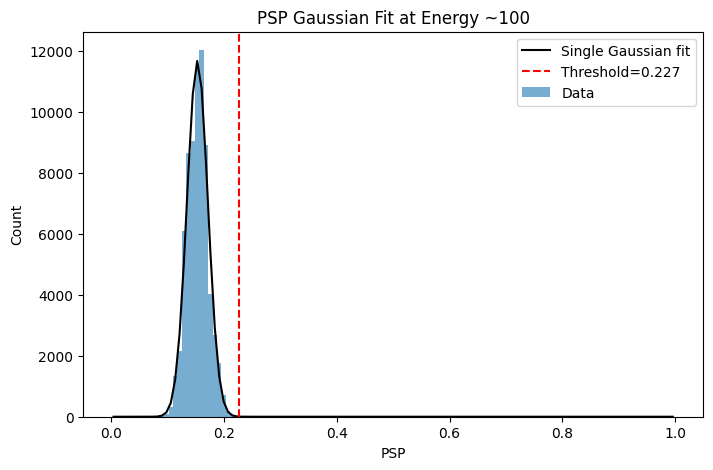

0.002781659320400655


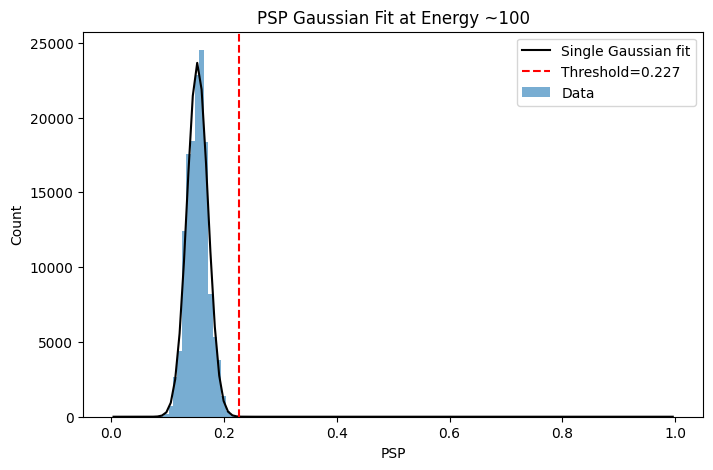

0.0027433527186336622


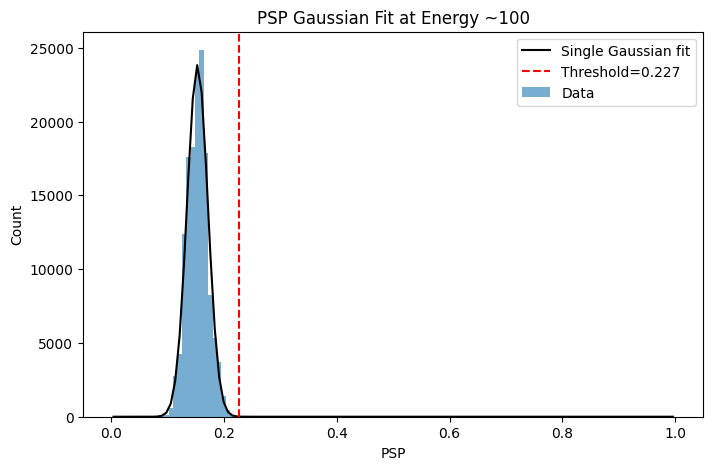

0.00238483344448665


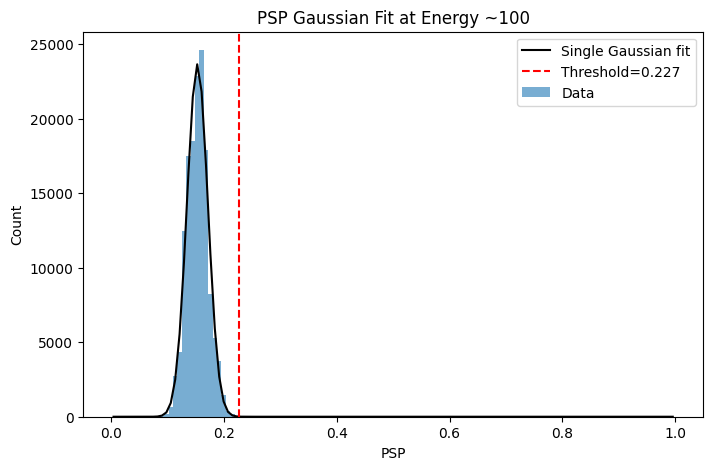

0.002705745275126265


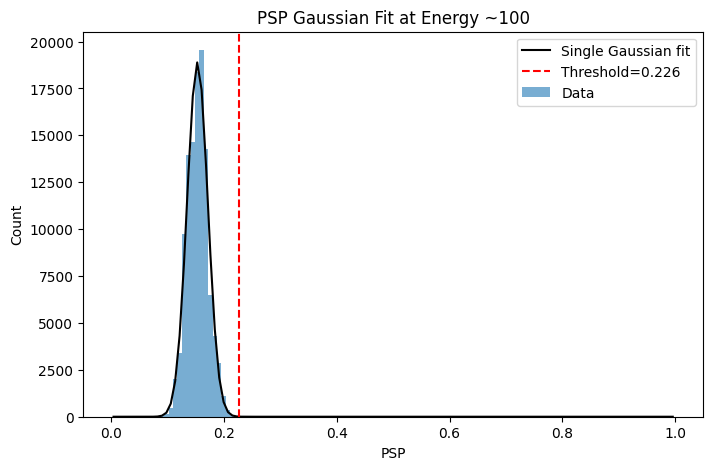

0.0023468193663684907


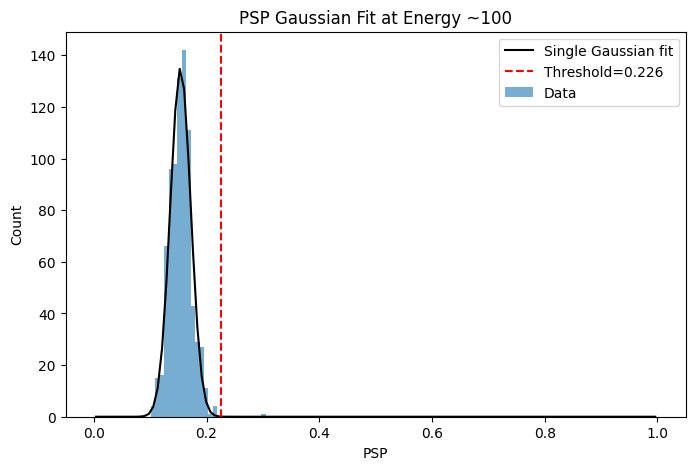

0.0014308970057226146


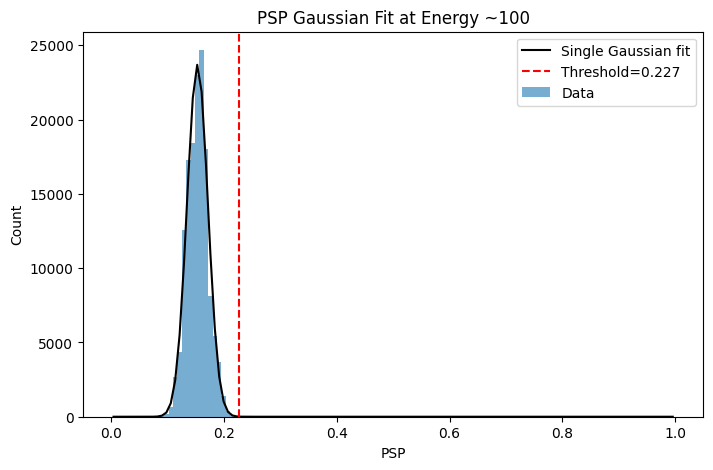

0.0026548873585336423


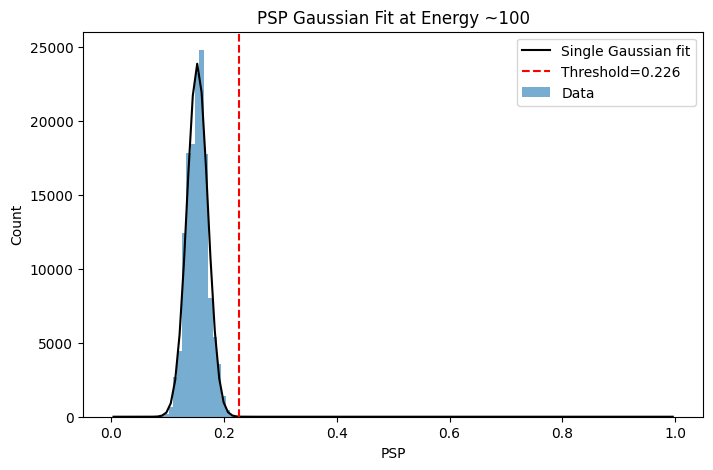

0.0024210638563743085


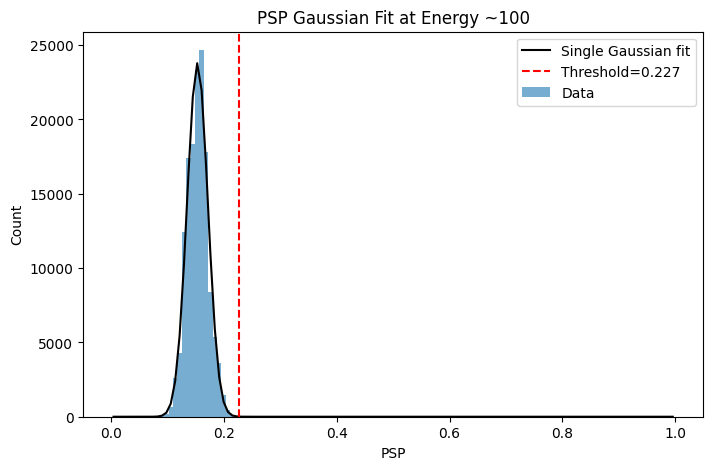

0.002480058402968524


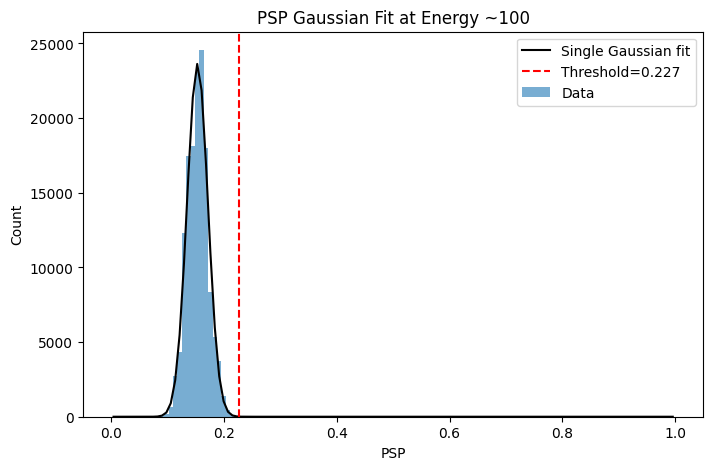

0.002540156254128041


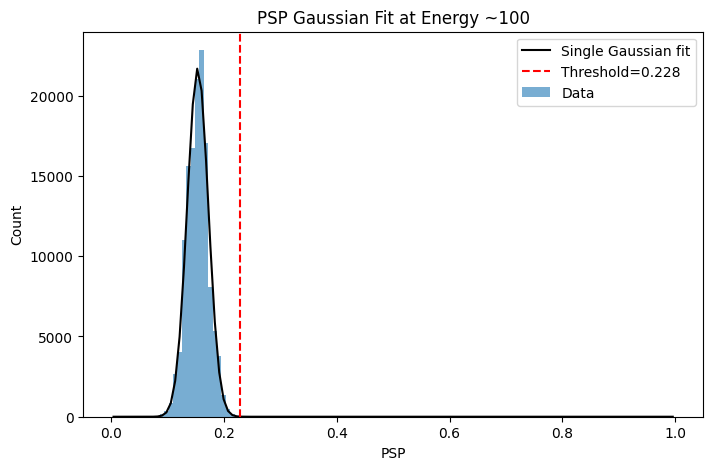

0.0024714760734688753


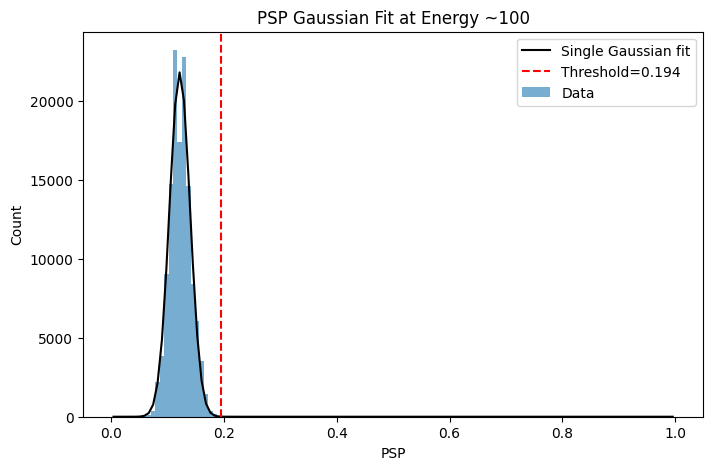

0.0024326528672799566


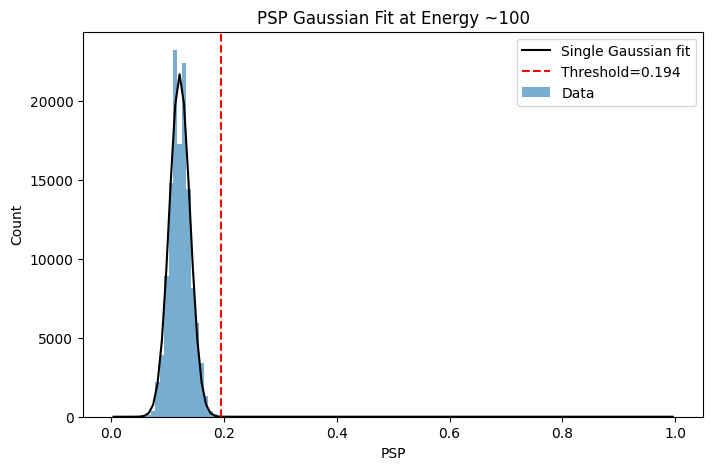

0.0021504005130773694


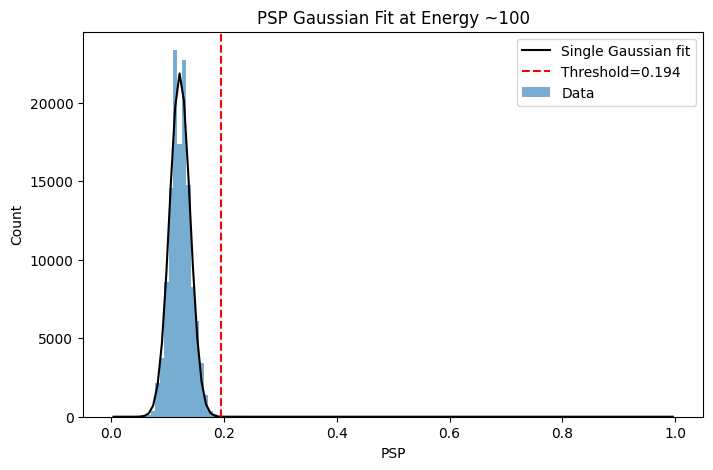

0.002111723252389687


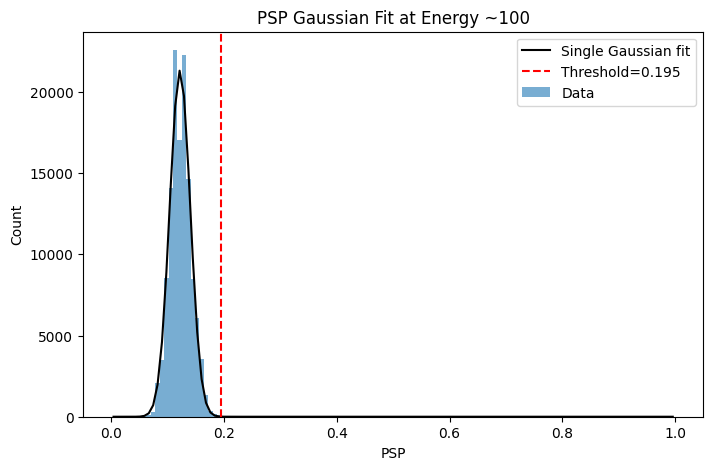

0.002448344419344481


In [ ]:
#For each start and end time in start and end, run get_psd_data and return a list of the PSPs
psd_list = []
neutron_rates = []
for start, end in time_periods:
    df_psd = get_psd_data(start, end, digitizer, channel_number)
    psp_threshold = find_psp_threshold_gaussian(df_psd, target_energy=100, num_sigma=4)
    psd_list.append(psp_threshold)
    neutron_data = get_event_data(start,end,f">{psp_threshold}",">500")
    neutron_data = reconstruct_ns_pulses(neutron_data)
    deltas = np.diff(neutron_data.index.values).astype("timedelta64[ns]") / np.timedelta64(1, "s")
    delta_sorted = np.sort(deltas)
    lam = 1 / np.mean(delta_sorted)
    print(lam)
    neutron_rates.append(lam)



Let's plot the full PSD histogram for this time period.

In [ ]:
def plot_psd(data, period=None, title="PSD", psp_threshold=None, ax=None):
    # Initialise histogram
    hist = np.zeros((512, 128), dtype=int)

    if period is not None:
        days = period.days
        hours = period.components.hours
        days_str = f"{days} day" if days == 1 else f"{days} days" if days > 0 else ""
        hours_str = f"{hours} hour" if hours == 1 else f"{hours} hours"
        period_string = f"{days_str}, {hours_str}" if days > 0 else hours_str
        period_string = period_string.strip(", ")
    else:
        period_string = None

    # Accumulate counts
    for row in data.itertuples(index=False):
        psp_bin, energy_bin, count = row
        if 0 <= energy_bin < 512 and 0 <= psp_bin < 128:
            hist[energy_bin, psp_bin] += int(count)

    # Define bin edges
    energy_edges = np.linspace(0, 4000, 513)  # 512 bins → 513 edges
    psp_edges = np.linspace(0, 1, 129)        # 128 bins → 129 edges

    # Plot with pcolormesh and log colour scale
    if ax is None:
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111)

    im = ax.pcolormesh(energy_edges, psp_edges, hist.T,
                      norm=mcolors.LogNorm(vmin=1, vmax=hist.max()),
                      cmap='viridis', shading='auto')
    ax.set_xlabel('Energy')
    ax.set_ylabel('PSP')
    if period_string is not None:
        ax.set_title(f"{title} ({period_string})")
    else:
        ax.set_title(title)

    # Draw horizontal red line at psp_threshold if provided
    if psp_threshold is not None:
        if 0 <= psp_threshold <= 1:  # Ensure threshold is within PSP range [0, 1]
            ax.axhline(y=psp_threshold, color='red', linestyle='-', label=f'PSP Threshold: {psp_threshold:.3f}')
            ax.legend()

    # Add colorbar
    plt.colorbar(im, ax=ax, label='Count (log scale)')

    if ax is None:
        plt.show()

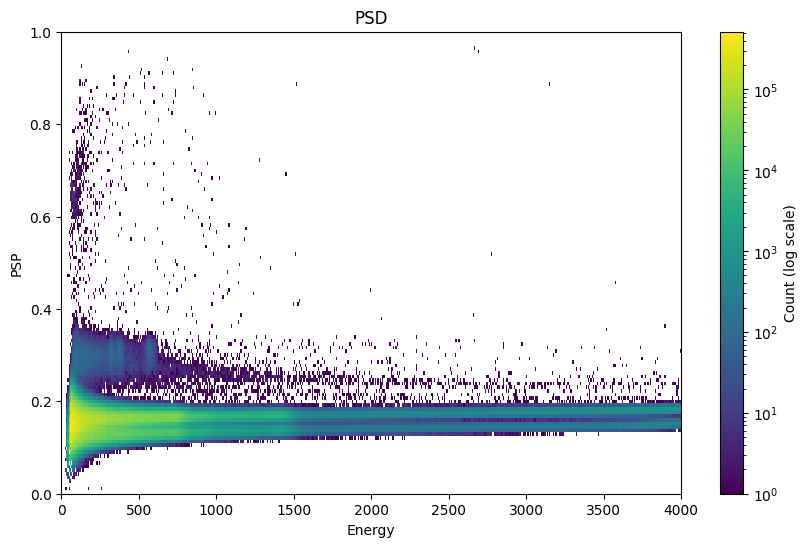

In [ ]:
psd_data = get_psd_data(start_time_str, end_time_str, digitizer, channel_number)
plot_psd(psd_data)

This range includes May 8, when the detectors were moved to the basement and had to be restarted after power loss. If we only include data before May 8, the bifurcation goes away

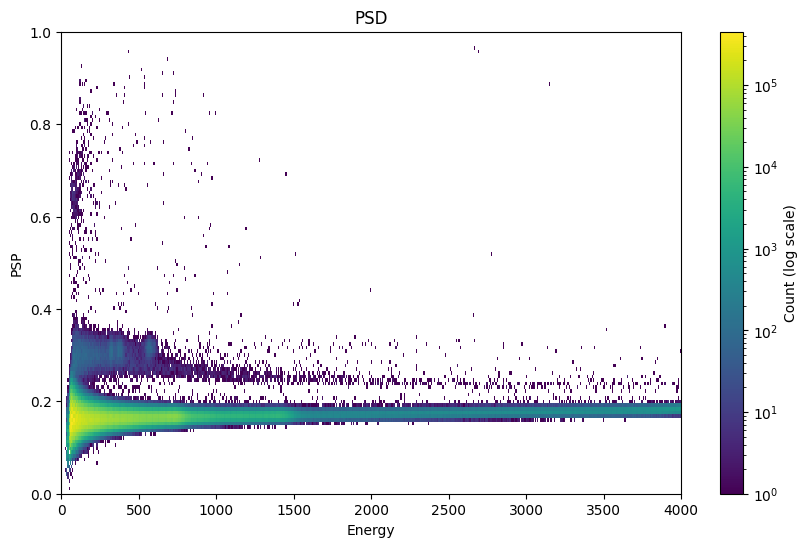

In [ ]:
psd_data = get_psd_data(start_time_str, '2025-05-08 00:00', digitizer, channel_number)
plot_psd(psd_data)

Now for the second half of the dataset on the 8 channel digitizer

In [ ]:
#Break range into 2 day periods

from datetime import datetime, timedelta

start_time_str = '2025-05-19 15:00'
end_time_str = '2025-06-23 12:00'

start_time = datetime.strptime(start_time_str, '%Y-%m-%d %H:%M')
end_time = datetime.strptime(end_time_str, '%Y-%m-%d %H:%M')

time_periods = []
current_start_time = start_time

while current_start_time < end_time:
    current_end_time = current_start_time + timedelta(days=2)
    if current_end_time > end_time:
        current_end_time = end_time
    time_periods.append((current_start_time.strftime('%Y-%m-%d %H:%M'), current_end_time.strftime('%Y-%m-%d %H:%M')))
    all_times.append((current_start_time.strftime('%Y-%m-%d %H:%M'), current_end_time.strftime('%Y-%m-%d %H:%M')))
    current_start_time = current_end_time

for start, end in time_periods:
    print(f"Start: {start}, End: {end}")

Start: 2025-05-19 15:00, End: 2025-05-21 15:00
Start: 2025-05-21 15:00, End: 2025-05-23 15:00
Start: 2025-05-23 15:00, End: 2025-05-25 15:00
Start: 2025-05-25 15:00, End: 2025-05-27 15:00
Start: 2025-05-27 15:00, End: 2025-05-29 15:00
Start: 2025-05-29 15:00, End: 2025-05-31 15:00
Start: 2025-05-31 15:00, End: 2025-06-02 15:00
Start: 2025-06-02 15:00, End: 2025-06-04 15:00
Start: 2025-06-04 15:00, End: 2025-06-06 15:00
Start: 2025-06-06 15:00, End: 2025-06-08 15:00
Start: 2025-06-08 15:00, End: 2025-06-10 15:00
Start: 2025-06-10 15:00, End: 2025-06-12 15:00
Start: 2025-06-12 15:00, End: 2025-06-14 15:00
Start: 2025-06-14 15:00, End: 2025-06-16 15:00
Start: 2025-06-16 15:00, End: 2025-06-18 15:00
Start: 2025-06-18 15:00, End: 2025-06-20 15:00
Start: 2025-06-20 15:00, End: 2025-06-22 15:00
Start: 2025-06-22 15:00, End: 2025-06-23 12:00


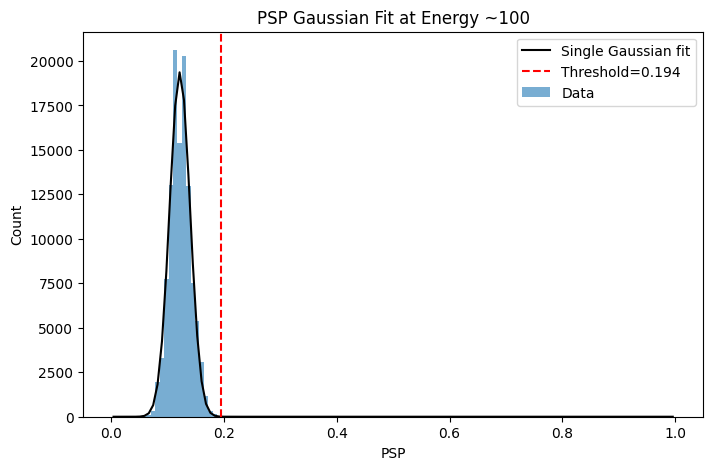

0.002323011198009627


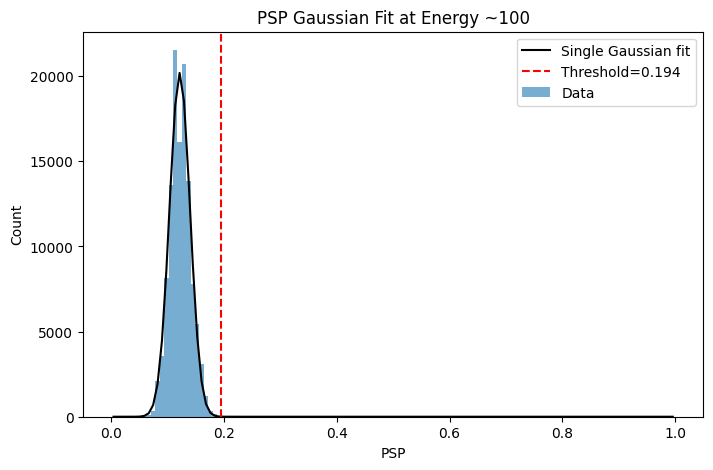

0.0022749021166892183


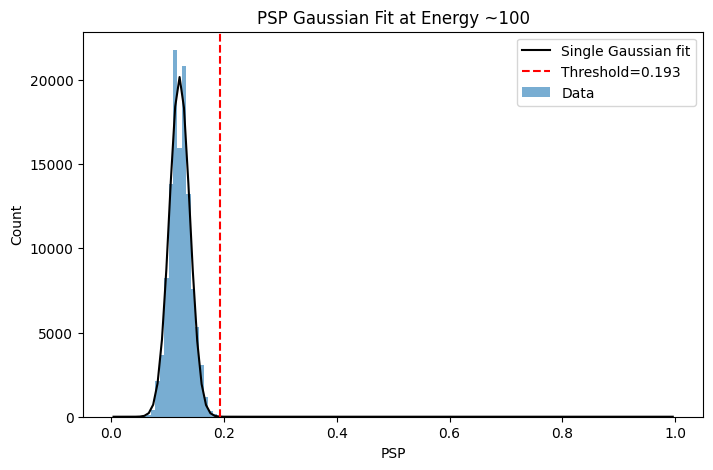

0.0023679496273039105


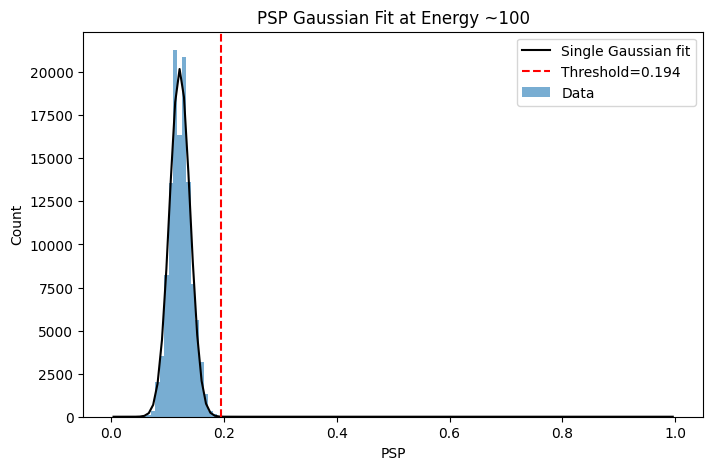

0.0024152665056607586


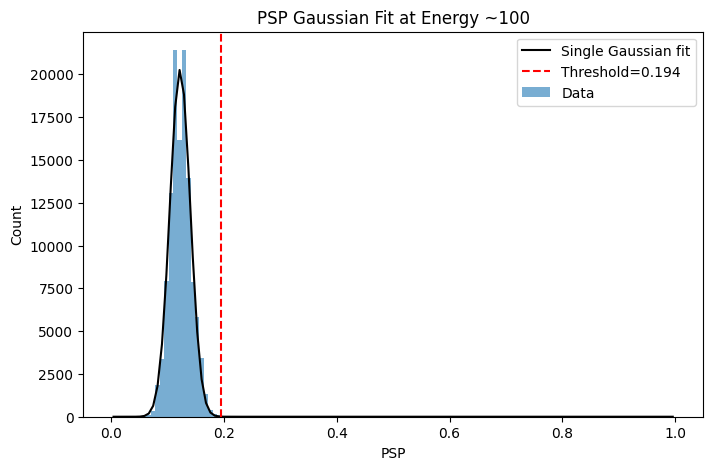

0.0022254091888689567


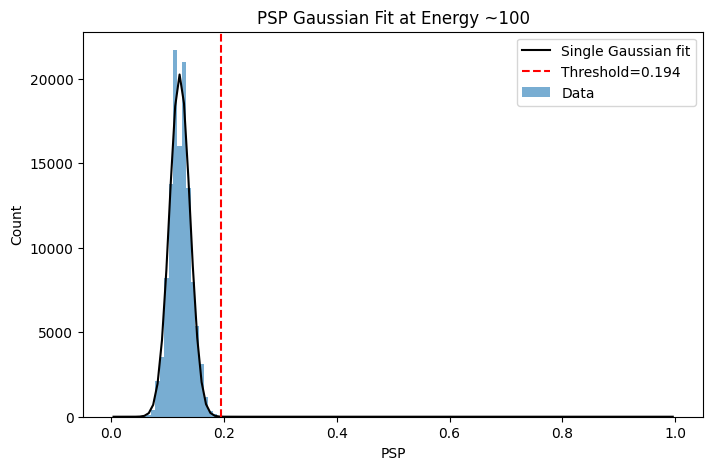

0.0023606950296074284


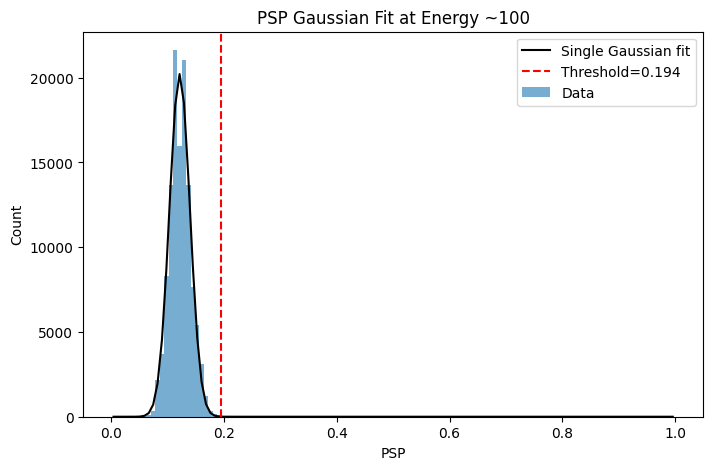

0.0022889163628429625


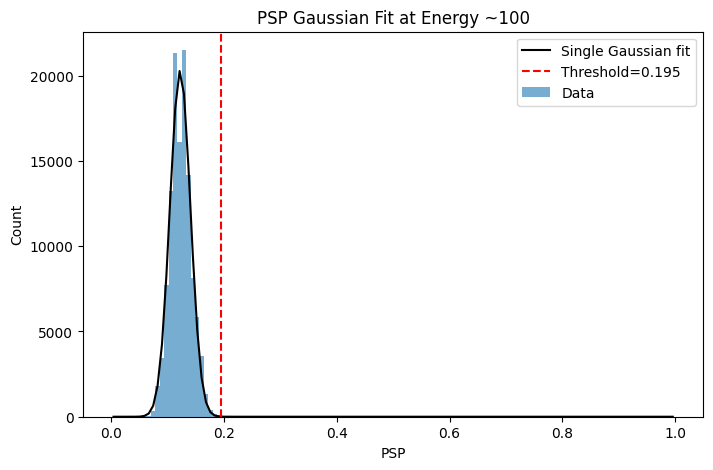

0.0023742871043610676


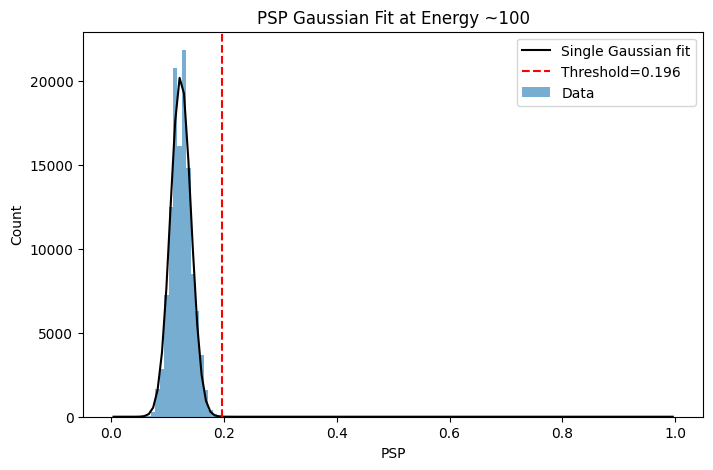

0.002342895140086394


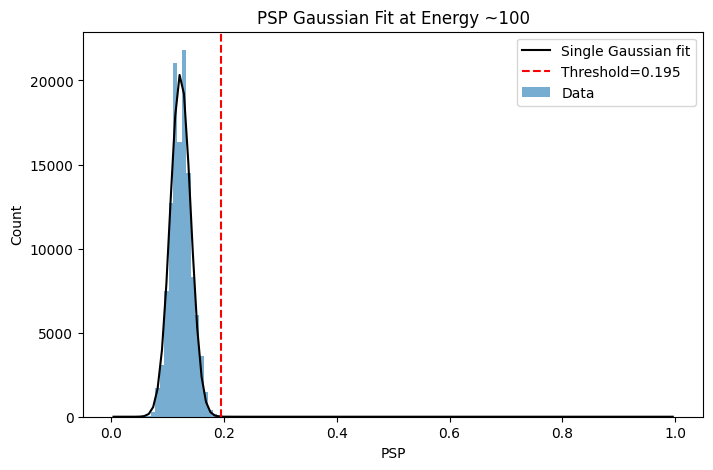

0.0023428074189268096


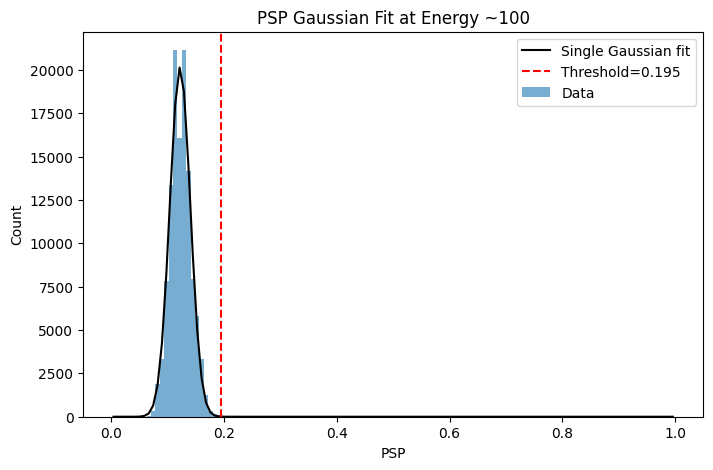

0.0023574003972068815


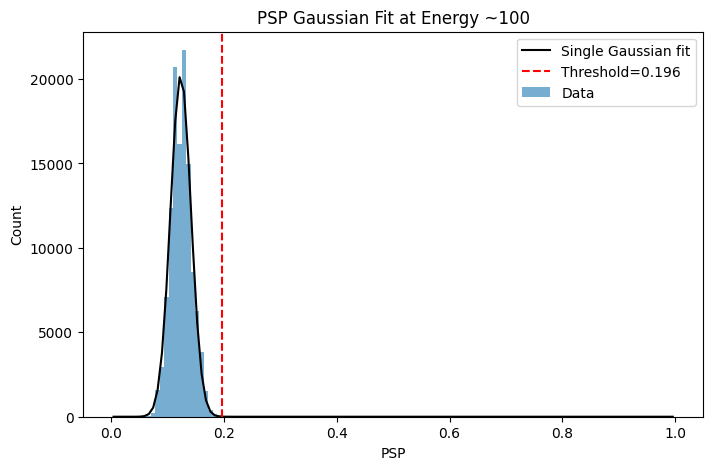

0.0025146802466779667


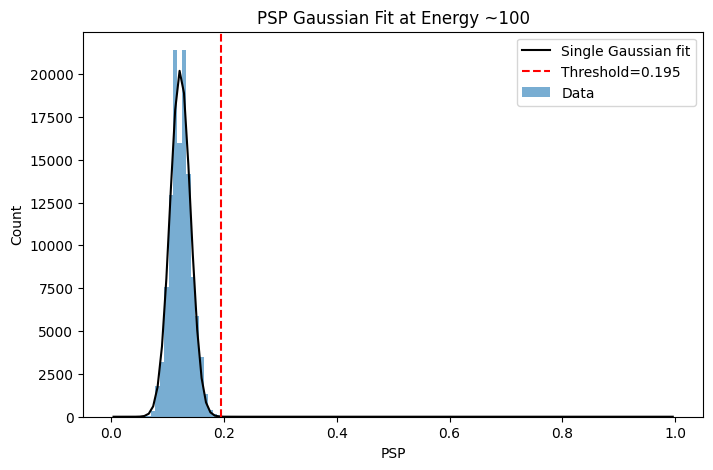

0.002386393435410676


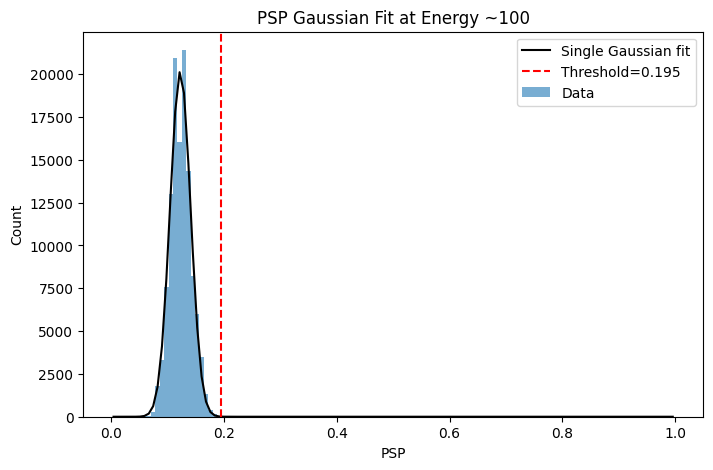

0.0022126632109470343


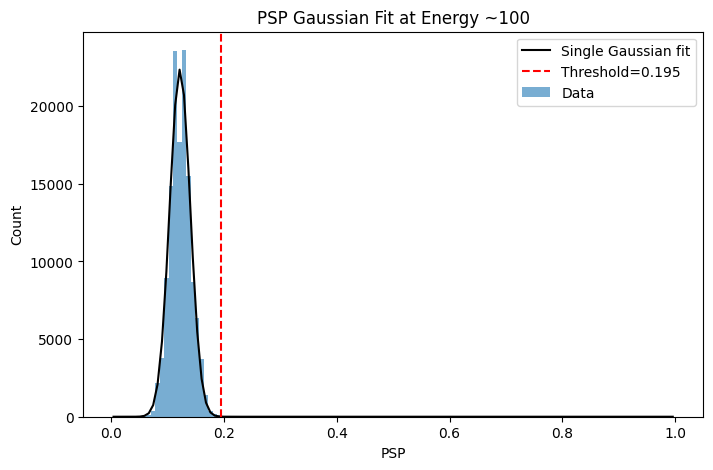

0.002204284293081836


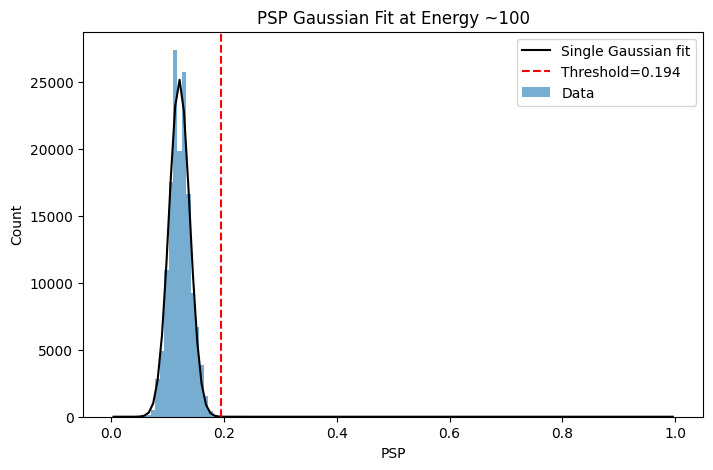

0.002263591993651414


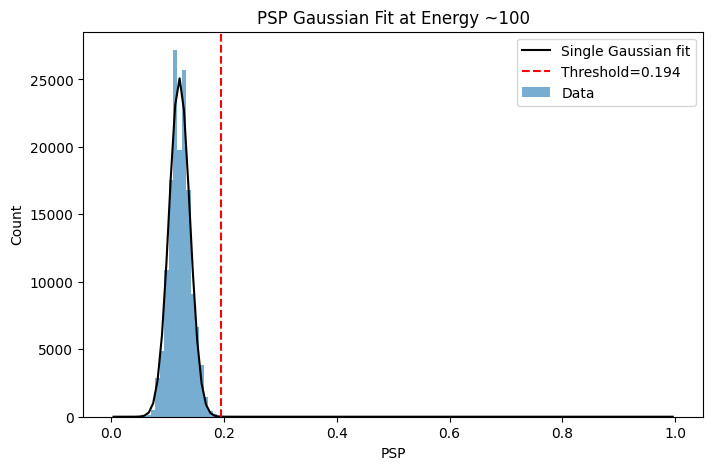

0.0023445544050717014


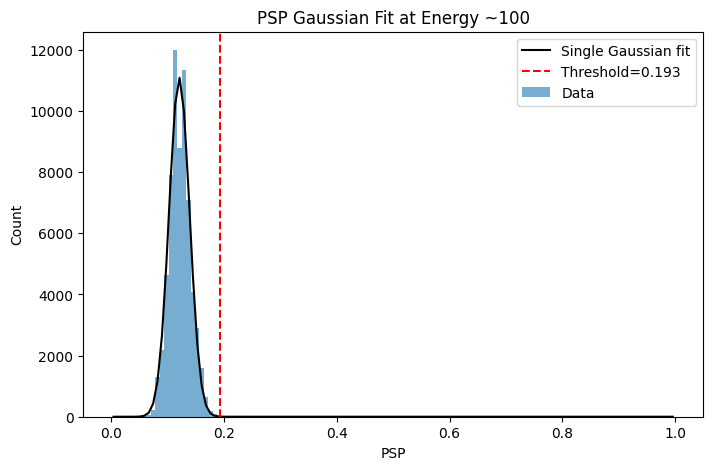

0.002202728635951698


In [ ]:
#For each start and end time in start and end, run get_psd_data and return a list of the PSPs

for start, end in time_periods:
    df_psd = get_psd_data(start, end, digitizer, channel_number)
    psp_threshold = find_psp_threshold_gaussian(df_psd, target_energy=100, num_sigma=4)
    psd_list.append(psp_threshold)
    neutron_data = get_event_data(start,end,f">{psp_threshold}",">500")
    neutron_data = reconstruct_ns_pulses(neutron_data)
    deltas = np.diff(neutron_data.index.values).astype("timedelta64[ns]") / np.timedelta64(1, "s")
    delta_sorted = np.sort(deltas)
    lam = 1 / np.mean(delta_sorted)
    print(lam)
    neutron_rates.append(lam)

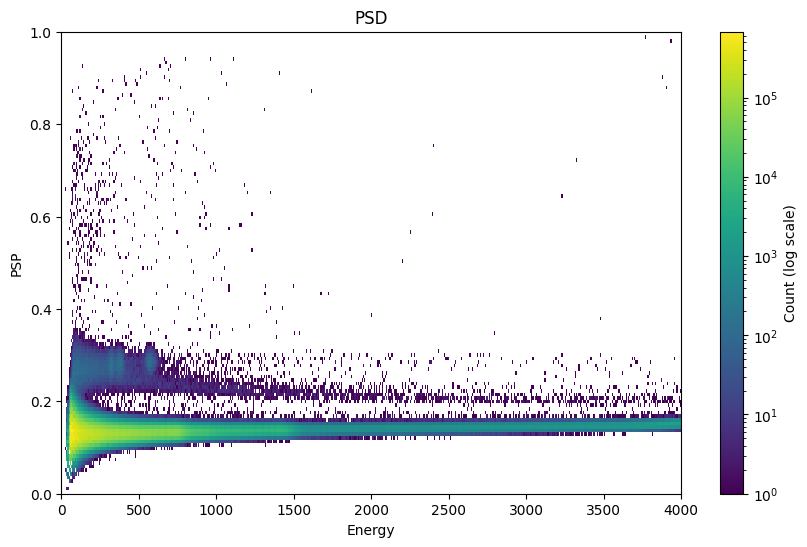

In [ ]:
psd_data = get_psd_data(start_time_str, end_time_str, digitizer, channel_number)
plot_psd(psd_data)

In [ ]:
psd_list

[np.float64(0.2268590166346246),
 np.float64(0.22724793079199102),
 np.float64(0.22658888579874553),
 np.float64(0.22691852250384814),
 np.float64(0.22639474133358242),
 np.float64(0.22620316398642137),
 np.float64(0.2268671358392776),
 np.float64(0.22630062869501866),
 np.float64(0.22655552311738056),
 np.float64(0.22697493758126014),
 np.float64(0.22836915740246164),
 np.float64(0.19430948707129153),
 np.float64(0.19378694407551256),
 np.float64(0.1937127258014713),
 np.float64(0.19465495280069667),
 np.float64(0.19402968255736766),
 np.float64(0.193982486282899),
 np.float64(0.19340043844201987),
 np.float64(0.19409758057532),
 np.float64(0.1944271780784862),
 np.float64(0.19391287013123792),
 np.float64(0.1939709547743298),
 np.float64(0.19493104113845597),
 np.float64(0.1955877532442979),
 np.float64(0.19499963049032612),
 np.float64(0.19471651184950373),
 np.float64(0.19582728263110416),
 np.float64(0.19467922040945745),
 np.float64(0.19527082628859985),
 np.float64(0.19471715114

In [ ]:
neutron_rates

[np.float64(0.002781659320400655),
 np.float64(0.0027433527186336622),
 np.float64(0.00238483344448665),
 np.float64(0.002705745275126265),
 np.float64(0.0023468193663684907),
 np.float64(0.0014308970057226146),
 np.float64(0.0026548873585336423),
 np.float64(0.0024210638563743085),
 np.float64(0.002480058402968524),
 np.float64(0.002540156254128041),
 np.float64(0.0024714760734688753),
 np.float64(0.0024326528672799566),
 np.float64(0.0021504005130773694),
 np.float64(0.002111723252389687),
 np.float64(0.002448344419344481),
 np.float64(0.002323011198009627),
 np.float64(0.0022749021166892183),
 np.float64(0.0023679496273039105),
 np.float64(0.0024152665056607586),
 np.float64(0.0022254091888689567),
 np.float64(0.0023606950296074284),
 np.float64(0.0022889163628429625),
 np.float64(0.0023742871043610676),
 np.float64(0.002342895140086394),
 np.float64(0.0023428074189268096),
 np.float64(0.0023574003972068815),
 np.float64(0.0025146802466779667),
 np.float64(0.002386393435410676),
 np

In [ ]:
all_times

[('2025-04-16 12:00', '2025-04-18 12:00'),
 ('2025-04-18 12:00', '2025-04-20 12:00'),
 ('2025-04-20 12:00', '2025-04-22 12:00'),
 ('2025-04-22 12:00', '2025-04-24 12:00'),
 ('2025-04-24 12:00', '2025-04-26 12:00'),
 ('2025-04-26 12:00', '2025-04-28 12:00'),
 ('2025-04-28 12:00', '2025-04-30 12:00'),
 ('2025-04-30 12:00', '2025-05-02 12:00'),
 ('2025-05-02 12:00', '2025-05-04 12:00'),
 ('2025-05-04 12:00', '2025-05-06 12:00'),
 ('2025-05-06 12:00', '2025-05-08 12:00'),
 ('2025-05-08 12:00', '2025-05-10 12:00'),
 ('2025-05-10 12:00', '2025-05-12 12:00'),
 ('2025-05-12 12:00', '2025-05-14 12:00'),
 ('2025-05-14 12:00', '2025-05-16 11:30'),
 ('2025-05-19 15:00', '2025-05-21 15:00'),
 ('2025-05-21 15:00', '2025-05-23 15:00'),
 ('2025-05-23 15:00', '2025-05-25 15:00'),
 ('2025-05-25 15:00', '2025-05-27 15:00'),
 ('2025-05-27 15:00', '2025-05-29 15:00'),
 ('2025-05-29 15:00', '2025-05-31 15:00'),
 ('2025-05-31 15:00', '2025-06-02 15:00'),
 ('2025-06-02 15:00', '2025-06-04 15:00'),
 ('2025-06-

In [ ]:
#Plot neutron_rates over time using pltly
#Convert all_times to timestamps
start_times = [period[0] for period in all_times]

fig = go.Figure(layout=dict(yaxis_title="Neutrons per second", showlegend=False, height=600, width=800))
fig.add_trace(go.Scattergl(name="Neutrons per second", x=start_times, y=neutron_rates))



In [ ]:
fig = go.Figure(layout=dict(yaxis_title="PSP", showlegend=False, height=600, width=800))
fig.add_trace(go.Scattergl(name="PSP", x=start_times, y=psd_list))

#Conclusion

Here we see the PSP distribution is roughly constant, except for a discrete event that occured when the chambers were moved to the LASER lab for laser treatment. Note that although this experiment lagged the other two by 10 days and so did not begin its laser treatment until May 19, the chamber needed to travel with the other two chambers as all three were run through a single multichannel digitizer. During the move, a cable was damaged, and other cables were shuffled around to replace the broken one. As a result of changing cables, the PSP distribution shifted. We therefore break our analysis up into two periods, and use the average PSP value for each period separately.